# Introduction

In [1]:
from google.colab import drive
drive.mount('/gdrive')
root = '/gdrive/My Drive/Colab Notebooks/MNIST-classification'

Mounted at /gdrive


# Importing Libraries and Data

In [2]:
# generel utility libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from utils import show_example, plot_training_history
from IPython.display import clear_output

# keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# keras tuner
!pip install keras-tuner
clear_output()
from keras_tuner import HyperModel, RandomSearch

# function to read matlab data file
from scipy.io import loadmat

In [3]:
# Loading Data
X = loadmat(f'{root}/data/mnist_training_data.mat')['training_data']
y = loadmat(f'{root}/data/mnist_training_label.mat')['training_label']

X_test = loadmat(f'{root}/data/mnist_test_data.mat')['test_data']
y_test = loadmat(f'{root}/data/mnist_test_label.mat')['test_label']

X_rot = loadmat(f'{root}/data/mnist-rot_training_data.mat')['train_data']
y_rot = loadmat(f'{root}/data/mnist-rot_training_label.mat')['train_label']

X_rot_test = loadmat(f'{root}/data/mnist-rot_test_data.mat')['test_data']
y_rot_test = loadmat(f'{root}/data/mnist-rot_test_label.mat')['test_label']

# Reshaping Data
X_rot = X_rot.reshape(-1, 28*28)
y_rot = y_rot.reshape(-1, 1).astype('int')

X_rot_test = X_rot_test.reshape(-1, 28*28)
y_rot_test = y_rot_test.reshape(-1, 1).astype('int')

# Scaling the Data to Maintain Homogeneity

We convert each image to have pixel value between 0 and 1.

In [4]:
mms = MinMaxScaler()

# Unrotated Data
X = mms.fit_transform(X)
X_test = mms.fit_transform(X_test)

# Rotated Data
X_rot = mms.fit_transform(X_rot)
X_rot_test = mms.fit_transform(X_rot_test)

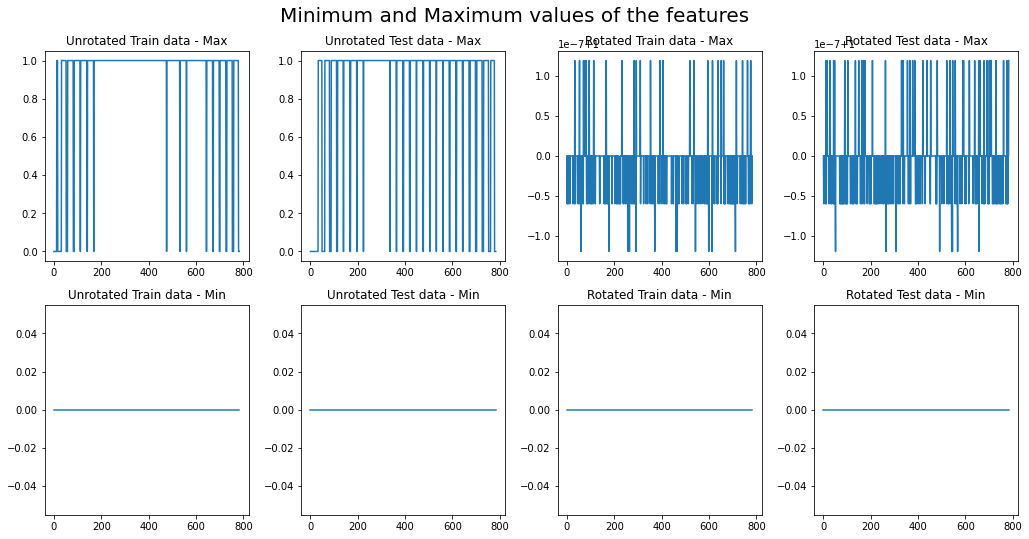

In [5]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(16, 8)
fig.patch.set_facecolor('white')
fig.suptitle('Minimum and Maximum values of the features', fontsize=20)
(urtr_max, urts_max, rotr_max, rots_max), (urtr_min, urts_min, rotr_min, rots_min) = axs

# Unrotated Train data
urtr_min.set_title('Unrotated Train data - Min')
urtr_min.plot(np.min(X, axis=0))
urtr_max.set_title('Unrotated Train data - Max')
urtr_max.plot(np.max(X, axis=0))

# Unrotated Test data
urts_min.set_title('Unrotated Test data - Min')
urts_min.plot(np.min(X_test, axis=0))
urts_max.set_title('Unrotated Test data - Max')
urts_max.plot(np.max(X_test, axis=0))

# Rotated Train data
rotr_min.set_title('Rotated Train data - Min')
rotr_min.plot(np.min(X_rot, axis=0))
rotr_max.set_title('Rotated Train data - Max')
rotr_max.plot(np.max(X_rot, axis=0))

# Rotated Test data
rots_min.set_title('Rotated Test data - Min')
rots_min.plot(np.min(X_rot_test, axis=0))
rots_max.set_title('Rotated Test data - Max')
rots_max.plot(np.max(X_rot_test, axis=0))

fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
fig.show()

# Testing the model fitted on unrotated data on rotated data

In [6]:
import pickle

with open(f"{root}/models/scaler_wo_pca.pkl", 'rb') as f:
    scaler = pickle.load(f)
Z_rot_test = scaler.transform(X_rot_test)

model = keras.models.load_model(f'{root}/models/nn_unrotated_model_wo_pca')

test_loss, test_acc = model.evaluate(scaler.transform(X_rot_test), y_rot_test, verbose=0)

print(f"Test Accuracy:  {test_acc :2.2%}")
print(f"Test Loss:      {test_loss :.6}")

Test Accuracy:  34.21%
Test Loss:      6.28675


As we can see accuracy falls drastically while classifying the rotated data. This implies that the previous model doesnot generalize for rotated digit image.

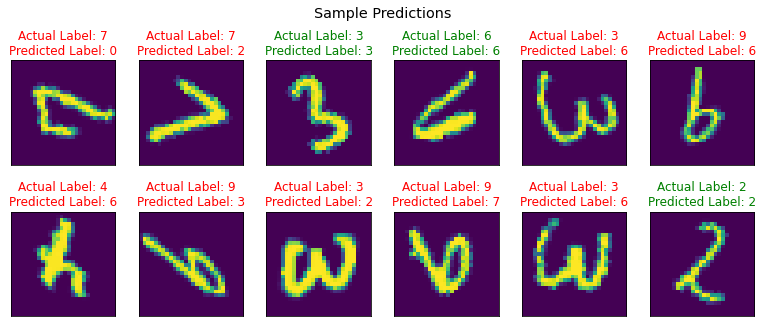

In [8]:
show_example(
    X=X_rot_test, 
    y=y_rot_test,
    y_pred=np.argmax(model.predict(Z_rot_test), axis=1)
)

To make a better classifier that can classify the unrotated data as well as the rotated data we combine these two datasets and train the model on the combined dataset.

# Combining Datasets

In [9]:
X_comb = np.concatenate((X, X_rot), axis=0)
y_comb = np.concatenate((y, y_rot), axis=0)

X_test_comb = np.concatenate((X_test, X_rot_test), axis=0)
y_test_comb = np.concatenate((y_test, y_rot_test), axis=0)

train_size, n_features = X_comb.shape
test_size, _ = X_test_comb.shape
seed = 0

In [10]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
train_idx, val_idx = [*sss.split(X_comb, y_comb)][0]

X_train_comb, X_val_comb = X_comb[train_idx, :], X_comb[val_idx, :]
y_train_comb, y_val_comb = y_comb[train_idx, :], y_comb[val_idx, :]

# Configuring GPU

In [12]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f"No. of GPUs available: {len(physical_devices)}")

No. of GPUs available: 1


# Selecting Model Architecture by Cross-validation

We select number of hidden layers and number of units in each layers by cross validation. We chose to vary number of hidden layers from 1 to 10 and for each number of layers we search for the optimum number of hidden units in each layer. The number of units in each hidden layer are chosen from the set $\{16i : i=1(1)32\}$. We take the model resulting the maximum validation accuracy for each number of layers.

## Building Hypermodel and Searching for the Best Model 

In [ ]:
class MyHyperModel(HyperModel):
    def __init__(self, classes, layers):
        self.classes = classes
        self.layers = layers

    def build(self, hp):
        # Build Model
        model = keras.Sequential()
        for i in range(self.layers):
            model.add(layers.Dense(
                units=hp.Choice(
                    f"layer_{i+1:02}", 
                    values=list(range(16, 513, 16))
                ),
                kernel_initializer='he_uniform',
                activation='relu'
            ))
            model.add(layers.Dropout(
                rate=hp.Float(
                    f"dropout_{i+1:02}", 0, 0.5, 0.01, default=0
                )
            ))
        model.add(layers.Dense(self.classes, activation='softmax'))

        # Compile Model
        model.compile(
            optimizer=keras.optimizers.Adam(0.001),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )
        return model

In [ ]:
params = {}
for i in range(10):
    print(f"Number of Hidden Layers: {i+1}")
    hypermodel = MyHyperModel(10, i+1)

    tuner = RandomSearch(
        hypermodel,
        objective='val_accuracy',
        max_trials=20,
        overwrite=True
    )

    es = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    tuner.search(
        X_train_comb, y_train_comb, validation_data=(X_val_comb, y_val_comb),
        epochs=5000, batch_size=5000, verbose=1 , callbacks=[es]
    )
    params[i+1] = tuner.get_best_hyperparameters()[0].values

Trial 20 Complete [00h 01m 00s]
val_accuracy: 0.9224193692207336

Best val_accuracy So Far: 0.9641935229301453
Total elapsed time: 00h 20m 05s
INFO:tensorflow:Oracle triggered exit


## Creating Models from the Best Model Architectures

In [41]:
def create_model(input_size, params):
    model = Sequential()
    model.add(layers.InputLayer(input_size))
    for i in range(1, 11):
        if f'layer_{i:02}' not in params.keys():
            break
        model.add(layers.Dense(
            units=params[f'layer_{i:02}'],
            activation='relu',
            kernel_initializer='he_uniform'
        ))
        model.add(layers.Dropout(
            rate=params[f'dropout_{i:02}']
        ))
    model.add(layers.Dense(10, activation='softmax'))
    return model

models = []
for param in params.values():
    model = create_model(n_features, param)
    models.append(model)

In [42]:
for model in models:
    print(model.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_130 (Dense)            (None, 480)               376800    
_________________________________________________________________
dropout_110 (Dropout)        (None, 480)               0         
_________________________________________________________________
dense_131 (Dense)            (None, 10)                4810      
Total params: 381,610
Trainable params: 381,610
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_132 (Dense)            (None, 416)               326560    
_________________________________________________________________
dropout_111 (Dropout)        (None, 416)               0         
___________________

## Training the Models

In [43]:
es = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    mode='auto', 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)

In [44]:
metrics = pd.DataFrame(columns=['n_layers', 'train_loss', 'train_acc', 
                                'val_loss', 'val_acc'])

for i, model in enumerate(models):
    print(f"Training Model {i+1}:")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001), 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )

    # training the model
    training_history = model.fit(
        X_train_comb, y_train_comb, validation_data=(X_val_comb, y_val_comb),
        epochs=5000, batch_size=5000,
        shuffle=True, verbose=1, callbacks=[es]
    )
    # Storing the training history in the model
    model.training_history = training_history
    clear_output()

    # Get and store acurracies and losses
    train_loss, train_acc = model.evaluate(X_train_comb, y_train_comb, batch_size=5000)
    valid_loss, valid_acc = model.evaluate(X_val_comb, y_val_comb, batch_size=5000)
    clear_output()

    metrics = metrics.append(dict(
        n_layers=(len(model.layers) - 1)/2,
        train_loss=train_loss,
        train_acc=train_acc,
        val_loss=valid_loss,
        val_acc=valid_acc
    ), ignore_index=True)

The training and validation accuracies and losses are stored in `metrics` for each number of layers. We compare the metrices and pick the model with best validation accuracy.

In [45]:
results = metrics.set_index('n_layers')
num_layers = results['val_acc'].idxmax().astype('int')
results

,train_loss,train_acc,val_loss,val_acc
n_layers,,,,
1.0,0.039485,0.994548,0.194465,0.94415
2.0,0.009544,0.999262,0.189004,0.94885
3.0,0.016972,0.996190,0.185551,0.94905
4.0,0.011433,0.997643,0.185309,0.95060
5.0,0.004523,0.999119,0.208827,0.95110
6.0,0.034256,0.991095,0.223500,0.94535
7.0,0.031158,0.991167,0.225136,0.94465
8.0,0.030932,0.991976,0.281666,0.93535
9.0,0.027215,0.993095,0.238403,0.94105


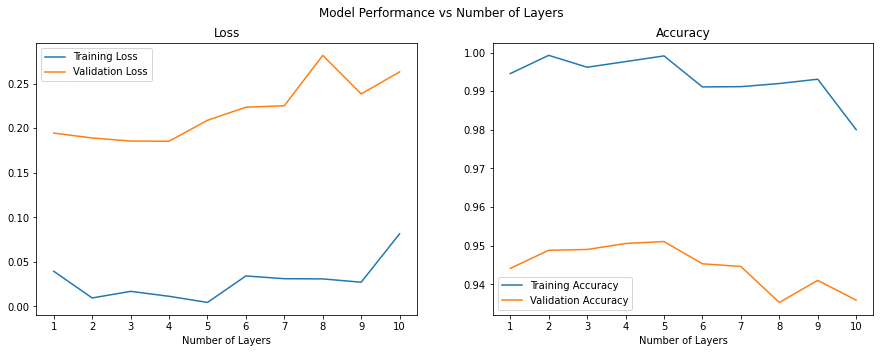

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Model Performance vs Number of Layers")
fig.set_size_inches(15, 5)

ax1.plot(results['train_loss'], label='Training Loss')
ax1.plot(results['val_loss'], label='Validation Loss')
ax1.set_xlabel('Number of Layers')
ax1.set_xticks(results.index)
ax1.set_title('Loss')
ax1.legend()

ax2.plot(results['train_acc'], label='Training Accuracy')
ax2.plot(results['val_acc'], label='Validation Accuracy')
ax2.set_xlabel('Number of Layers')
ax2.set_xticks(results.index)
ax2.set_title('Accuracy')
ax2.legend()

fig.show()

We have plotted the metrics for each number of layers. From the figure it is apparent that validation accuracy is maximum with 3 hidden layers. The number of units for which validation accuracy is maximum are 480, 400, 352.

# Picking Best Model

In [53]:
model = models[num_layers - 1]
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 480)               376800    
_________________________________________________________________
dropout_120 (Dropout)        (None, 480)               0         
_________________________________________________________________
dense_145 (Dense)            (None, 368)               177008    
_________________________________________________________________
dropout_121 (Dropout)        (None, 368)               0         
_________________________________________________________________
dense_146 (Dense)            (None, 512)               188928    
_________________________________________________________________
dropout_122 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_147 (Dense)            (None, 416)             

# Training History and Model Performace

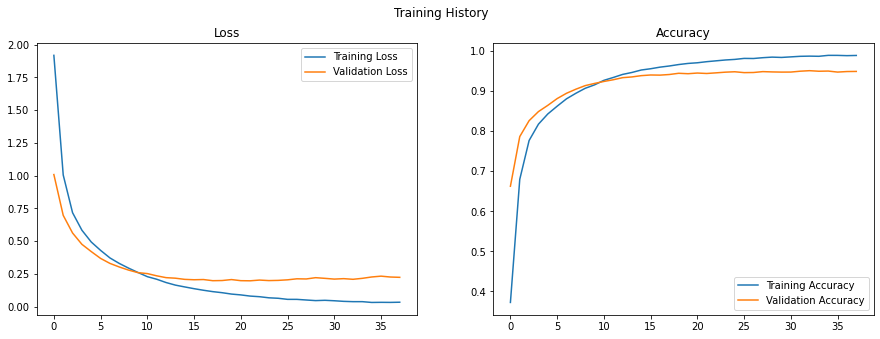

In [54]:
plot_training_history(model.training_history)

In [55]:
train_loss, train_acc = model.evaluate(X_train_comb, y_train_comb, verbose=0)
test_loss,  test_acc  = model.evaluate(X_test_comb,  y_test_comb,  verbose=0)

print(f"Training Accuracy: {train_acc:2.2%}")
print(f"Test Accuracy:     {test_acc :2.2%}")
print(f"Training Loss: {train_loss:.6}")
print(f"Test Loss:     {test_loss :.6}")

Training Accuracy: 99.91%
Test Accuracy:     91.54%
Training Loss: 0.00452322
Test Loss:     0.345559


In [57]:
model.save(f"{root}/models/nn_merged_model")

INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/MNIST-classification/models/nn_merged_model/assets
